In [ ]:
# default_exp core.utils.data

# Data Utility
> Functions for Data Downloading , Loading Images

In [ ]:
#hide
from nbdev.showdoc import *
from nbdev.export import *

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# export
from collections import UserDict
from typing import *

import os
import cv2
from PIL import Image

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from fastcore.all import ifnone, delegates, Path

from torchvision.datasets.utils import download_and_extract_archive
from torchvision.datasets.folder import IMG_EXTENSIONS

from lightning_cv.core.utils.common import Registry, default_logger, show_images

<IPython.core.display.Javascript object>

In [ ]:
# hide
# export
# initalize logger
logger = default_logger()

<IPython.core.display.Javascript object>

In [ ]:
# export
def norm_ip(img, low, high):
    "normalize `img` with low and high"
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))


def norm_range(t, value_range):
    "normalize tensor t for given value range"
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

<IPython.core.display.Javascript object>

In [ ]:
# export
# copy from : https://github.com/fastai/fastai/blob/master/nbs/04_data.external.ipynb
# a thin wrapper over the original fastai.URLs
class Urls:
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd() / "data"
    DOGS = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
    BEES = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

<IPython.core.display.Javascript object>

## Downloading

download a data from links in `Urls`

In [ ]:
# export
@delegates(download_and_extract_archive)
def download_data(url: str, data_path: str = None, **kwargs):
    "downloads and extracts the data at `Urls.LOCAL_PATH` if datapath is None"
    data_path = ifnone(data_path, Urls.LOCAL_PATH)
    os.makedirs(Urls.LOCAL_PATH, exist_ok=True)
    download_and_extract_archive(url, Urls.LOCAL_PATH, **kwargs)
    logger.info(f"Data downloaded to {Path(data_path)}")

<IPython.core.display.Javascript object>

In [ ]:
# hide
from nbdev.imports import Config as NbdevConfig
import matplotlib.pyplot as plt

nbdev_path = str(NbdevConfig().path("nbs_path") / "data")
nbdev_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

<IPython.core.display.Javascript object>

In [ ]:
# hide
download_data(Urls.DOGS, data_path=nbdev_path)

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/13 20:25:44 __main__]: Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


<IPython.core.display.Javascript object>

In [ ]:
# hide
data = Path(nbdev_path) / "cats_and_dogs_filtered/train"
image = data / "dogs/dog.0.jpg"

<IPython.core.display.Javascript object>

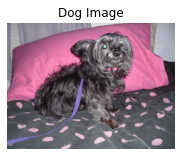

<IPython.core.display.Javascript object>

In [ ]:
# hide
import numpy as np
from PIL import Image

show_images(ims=[np.array(Image.open(image))], titles=["Dog Image"])

## Loaders
> Utils for reading Images

In [ ]:
# export
LOADER_REGISTERY = Registry("LOADERS")
LOADER_REGISTERY.__doc__ = "Registery of Loaders, `Loaders` are used to load in Images"

<IPython.core.display.Javascript object>

Load an Image using PIL - 

In [ ]:
# export
@LOADER_REGISTERY.register()
def pil_loader(path) -> Image.Image:
    "loads an image using PIL, mainly used for torchvision transformations"
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

<IPython.core.display.Javascript object>

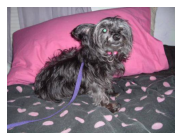

<IPython.core.display.Javascript object>

In [ ]:
im = LOADER_REGISTERY.get("pil_loader")(image)
show_images([im])

Load Image using cv2 -

In [ ]:
# export
@LOADER_REGISTERY.register()
def cv2_loader(path):
    "loads an image using cv2, mainly used for albumentations transformations"
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

<IPython.core.display.Javascript object>

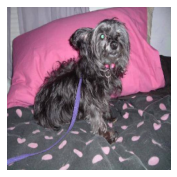

<IPython.core.display.Javascript object>

In [ ]:
im = LOADER_REGISTERY.get("cv2_loader")(str(image))
im = cv2.resize(im, (255, 255))
show_images(ims=[im])

## Utilities for Pandas
> Set of utility functions for working with Image data and pandas

In [ ]:
# export
def folder2df(folder: str, extension: list = None, shuffle: bool = False):
    "parses all the images in a folder into a pandas dataframe."
    extensions = ifnone(extension, IMG_EXTENSIONS)

    image_list = []
    target_list = []

    for f in os.listdir(folder):
        curr_path = os.path.join(folder, f)
        if os.path.isdir(curr_path):
            for image in os.listdir(curr_path):
                image_path = os.path.join(curr_path, image)
                image_tgt = f
                if image_path.lower().endswith(extensions):
                    image_list.append(image_path)
                    target_list.append(image_tgt)

    logger.info(
        f"Found {len(image_list)} files belonging to {len(set(target_list))} classes."
    )

    dataframe = pd.DataFrame()
    dataframe["image_id"] = image_list
    dataframe["target"] = target_list
    if shuffle:
        dataframe = dataframe.sample(frac=1).reset_index(inplace=False, drop=True)
    return dataframe

<IPython.core.display.Javascript object>

The folder stucture must be as follows - 
```
folder
|- class1
| |- image1
| |- image2
| |- image3
...
|- class2
| |- image1
| |- image2
| |- image3
|- class2
| |- image1
| |- image2
| |- image3
...
...
```

the `classes` in the folder will be given as `targets` and path of `image` will be stored in `image_id`

In [ ]:
# hide
pd.set_option("display.max_colwidth", None)
df = folder2df(data, shuffle=True)
df.head()

INFO [03/13 20:25:49 __main__]: Found 2000 files belonging to 2 classes.


,image_id,target
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.875.jpg,cats
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.560.jpg,dogs
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.709.jpg,dogs
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.234.jpg,cats
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.770.jpg,cats


<IPython.core.display.Javascript object>

In [ ]:
# export
@delegates(StratifiedKFold)
def stratify_df(
    df: pd.DataFrame,
    y: str = None,
    fold_col: str = None,
    shuffle: bool = False,
    **kwargs
):
    """makes stratified folds in `df`. The Id of the OOF Validation
    fold will be inserted in `fold_col`. `y` is the name of the column to
    the dependent variable.
    """
    # preserve the original copy of the dataframe
    data = df.copy()
    skf = StratifiedKFold(**kwargs)
    fold_col = ifnone(fold_col, "kfold")

    ys = data[y]
    data[fold_col] = -1

    for i, (train_index, test_index) in enumerate(skf.split(X=data, y=ys)):
        data.loc[test_index, "kfold"] = i

    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    return data

<IPython.core.display.Javascript object>

In [ ]:
# hide
df1 = stratify_df(df, y="target", shuffle=True)
df1.head()

,image_id,target,kfold
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.115.jpg,dogs,1
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.213.jpg,cats,2
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.948.jpg,cats,1
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.681.jpg,cats,2
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.780.jpg,cats,1


<IPython.core.display.Javascript object>

## DatasetCalalog
> A global dictionary that stores information about the `Datasets` and how to obtain them.

In [ ]:
# export
class _DatasetCatalog(UserDict):
    """
    A global dictionary that stores information about the datasets and how to obtain them.
    It contains a mapping from strings
    (which are names that identify a dataset, e.g. "my_dataset_train")
    to a function which parses the instanitiates the `Dataset` obj.

    From - https://github.com/facebookresearch/detectron2/blob/master/detectron2/data/catalog.py
    """

    def register(self, name, func):
        """
        Args:
            name (str): the name that identifies a dataset, e.g. "coco_2014_train".
            func (callable): a callable which takes no arguments and returns a list of dicts.
                It must return the same results if called multiple times.
        """
        assert callable(
            func
        ), "You must register a function with `DatasetCatalog.register`!"
        assert name not in self, "Dataset '{}' is already registered!".format(name)
        self[name] = func

    def get(self, name, **kwargs):
        """
        Call the registered function and return its results.
        Args:
            name (str): the name that identifies a dataset, e.g. "coco_2014_train".
        Returns:
            list[dict]: dataset annotations.
        """
        try:
            f = self[name]
        except KeyError as e:
            raise KeyError(
                "Dataset '{}' is not registered! Available datasets are: {}".format(
                    name, ", ".join(list(self.keys()))
                )
            ) from e
        return f(**kwargs)

    def list(self) -> List[str]:
        """
        List all registered datasets.
        Returns:
            list[str]
        """
        return list(self.keys())

    def remove(self, name):
        """
        Alias of ``pop``.
        """
        self.pop(name)

    def __str__(self):
        return "DatasetCatalog(registered datasets: {})".format(", ".join(self.keys()))

    __repr__ = __str__

<IPython.core.display.Javascript object>

## Export -

In [ ]:
# hide
notebook2script()

Converted 00_config.ipynb.
Converted 00a_core.utils.common.ipynb.
Converted 00b_core.utils.data.ipynb.
Converted 00c_core.optim.ipynb.
Converted 00d_core.schedules.ipynb.
Converted 00e_core.layers.ipynb.
Converted 00f_core.losses.py.ipynb.
Converted 01a_classification.data.transforms.ipynb.
Converted 01b_classification.data.datasets.ipynb.
Converted 01c_classification.modelling.backbones.ipynb.
Converted 01d_classification.modelling.classifiers.ipynb.
Converted 01e_classification.modelPL.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>